# Long Short Term Memory Temperature Modelling

To start with we will do some data preprocessing:

In [49]:
import os
import numpy as np
from scipy import signal
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta

THRESHOLD_TEMP = 18 + 1.0/3

In [50]:
max_daily_dataset = nc.Dataset('../../datasets/tasmax_hadukgrid_uk_region_day_19600101-20211231.nc')
min_daily_dataset = nc.Dataset('../../datasets/tasmin_hadukgrid_uk_region_day_19600101-20211231.nc')
region = 10

def convert_hours_to_datetime(hours):
    base_date = datetime(1800, 1, 1, 0, 0, 0)  # Base date for the calculation
    delta = timedelta(hours=hours)  # Create a timedelta based on the hours
    # Add the timedelta to the base date to get the resulting datetime
    result_datetime = base_date + delta
    return result_datetime.date()

region_daily_min = min_daily_dataset['tasmin'][:, region]
region_daily_max = max_daily_dataset['tasmax'][:, region]
data_dict = {'min': region_daily_min, 'max': region_daily_max, 'time': min_daily_dataset['time'][:]}
df = pd.DataFrame(data=data_dict)
df['date'] = df['time'].apply(convert_hours_to_datetime)
df['avg'] = (df['min'] + df['max'])/2
df['date'] = pd.to_datetime(df['date'])
df.head(10)

,min,max,time,date,avg
0,4.305863,6.601297,1402524.0,1960-01-01,5.453580
1,-1.411669,4.437036,1402548.0,1960-01-02,1.512684
2,-1.022055,9.284908,1402572.0,1960-01-03,4.131426
3,1.510127,8.090085,1402596.0,1960-01-04,4.800106
4,1.510083,5.732871,1402620.0,1960-01-05,3.621477
5,1.451583,6.028572,1402644.0,1960-01-06,3.740077
6,-0.571935,4.645021,1402668.0,1960-01-07,2.036543
7,-2.635523,4.546370,1402692.0,1960-01-08,0.955423
8,-0.143063,4.064202,1402716.0,1960-01-09,1.960569
9,-4.550033,4.936753,1402740.0,1960-01-10,0.193360


Single step CNNs are designed to make single predictions on the next token in a sequence. This is poorly suited to our needs, which are the number of degree days over an entire period. Therefore instead of attempting to model the temperature dynamics of each day (which is chaotic and very difficult to do accurately over long periods of time, eg a whole season) we will instead attempt to model the underlying of our products. That is the number of degree days in a given season.

## Degree Day Data Formatting

Firstly, we will construct the data into two periods, these periods are the contract type as specified by CME.

- HDD/CAT Seasonal Strips (Nov-Mar & Dec-Feb)
- CDD/CAT Seasonal Strips (May-Sep & Jul-Aug)



In [51]:
cdd_start_month = 5
cdd_end_month = 9
cdd_df = df[(df['date'].dt.month >= cdd_start_month) & (df['date'].dt.month <= cdd_end_month)]

def cooling_degree_day(temp):
    return np.maximum(temp - THRESHOLD_TEMP, 0)
 
cdd_df['dd'] = cooling_degree_day(cdd_df['avg'])
cdd_summed_data = cdd_df.groupby(cdd_df['date'].dt.year).sum()
# Create a new DataFrame indexed by year
cdd_by_year = pd.DataFrame(cdd_summed_data).reset_index()[['date', 'dd']]
cdd_by_year.head()

/tmp/ipykernel_42817/1306689716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdd_df['dd'] = cooling_degree_day(cdd_df['avg'])
/tmp/ipykernel_42817/1306689716.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cdd_summed_data = cdd_df.groupby(cdd_df['date'].dt.year).sum()


,date,dd
0,1960,0.0
1,1961,0.0
2,1962,0.0
3,1963,0.0
4,1964,0.0


In [52]:
hdd_start_month = 11
hdd_end_month = 3
hdd_df = df[(df['date'].dt.month >= cdd_start_month) | (df['date'].dt.month <= cdd_end_month)]

def heating_degree_day(temp):
    return np.maximum(THRESHOLD_TEMP - temp, 0)
 
hdd_df['dd'] = heating_degree_day(hdd_df['avg'])

hdd_summed_data = hdd_df.groupby(hdd_df['date'].dt.year).sum()
# Create a new DataFrame indexed by year
hdd_by_year = pd.DataFrame(hdd_summed_data).reset_index()[['date', 'dd']]
hdd_by_year.head()

/tmp/ipykernel_42817/373651965.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hdd_summed_data = hdd_df.groupby(hdd_df['date'].dt.year).sum()


,date,dd
0,1960,3772.268333
1,1961,3799.703175
2,1962,4077.795999
3,1963,4151.285499
4,1964,3865.240234


## LSTM testing

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Create toy data
def generate_data(length=1000, n_features=1):
    t = np.arange(0, length)
    x = np.sin(0.01 * t) + 0.5 * np.random.rand(length)
    x = x.reshape((length, n_features))
    return x

# Define LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMForecaster, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Train the model
def train_model(model, data, target, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 50 == 0:
            print(data.shape)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Forecast multiple steps ahead
def forecast(model, data, steps):
    forecasts = data.tolist()
    for i in range(steps):
        model.eval()
        input_data = torch.tensor(forecasts[-sequence_length:], dtype=torch.float32)
        print(input_data.shape)
        prediction = model(input_data)
        forecasts.append(prediction.item())
    return forecasts[-steps:]

# Generate data
data = generate_data()
sequence_length = 100
n_features = 1

# Prepare data for training
X = []
y = []
for i in range(len(data)-sequence_length-1):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [16]:
# Define hyperparameters
input_dim = n_features
hidden_dim = 64
num_layers = 1
output_dim = n_features
learning_rate = 0.001
epochs = 100

# Initialize and train the model
model = LSTMForecaster(input_dim, hidden_dim, num_layers, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [21]:
train_model(model, X, y, optimizer, criterion, epochs)

torch.Size([899, 100, 1])
Epoch [50/100], Loss: 0.0266
torch.Size([899, 100, 1])
Epoch [100/100], Loss: 0.0238


In [25]:
# Forecast 10 steps ahead
forecast_steps = 10
forecasted_data = forecast(model, torch.tensor([data[-sequence_length:]], dtype=torch.float32), forecast_steps)

torch.Size([1, 100, 1])


TypeError: not a sequence

NameError: name 'forecasted_data' is not defined

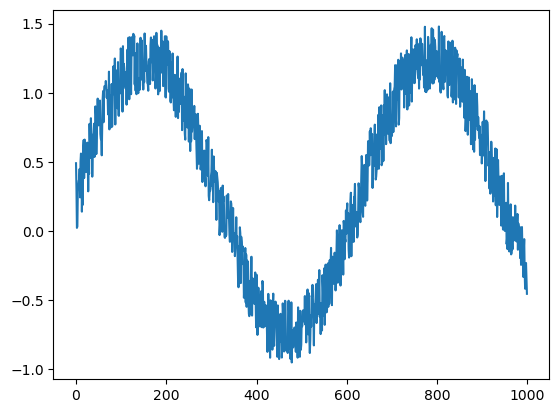

In [15]:
# Plot the results
plt.plot(np.arange(len(data)), data, label='Original Data')
plt.plot(np.arange(len(data), len(data) + forecast_steps), forecasted_data, label='Forecast')
plt.legend()
plt.show()